In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from tqdm.auto import tqdm
import huggingface_hub as hf
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from typing import List, Dict, Union, Tuple
from transformers import AutoTokenizer, AutoModel

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 256)

plt.style.use('seaborn-v0_8')
load_dotenv()
hf.login(os.environ["HF_TOKEN"])
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print("CUDA_VISIBLE_DEVICES:", os.environ["CUDA_VISIBLE_DEVICES"], "HF_HOME:", os.environ["HF_HOME"])

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


CUDA_VISIBLE_DEVICES: 0 HF_HOME: /local1/mohsenfayyaz/.hfcache/


In [2]:
# DATASET = "re-docred_facebook--contriever-msmarco_7170.pkl"
DATASET = "re-docred_facebook--dragon-plus-query-encoder_7170.pkl"
# DATASET = "re-docred_OpenMatch--cocodr-base-msmarco_7170.pkl.gz"

hf.hf_hub_download(repo_id="Retriever-Contextualization/datasets", filename=f"results/{DATASET}", repo_type="dataset", local_dir="hf/")

'hf/results/re-docred_facebook--dragon-plus-query-encoder_7170.pkl'

In [3]:
df_raw = pd.read_pickle(f"./hf/results/{DATASET}")
print(df_raw.attrs)
df_raw.head(1)

{'model': 'facebook/dragon-plus-query-encoder', 'query_model': 'facebook/dragon-plus-query-encoder', 'context_model': 'facebook/dragon-plus-context-encoder', 'pooling': 'cls', 'dataset': 're-docred', 'corpus_size': 105925, 'eval': {'ndcg': {'NDCG@1': 0.47685, 'NDCG@3': 0.52523, 'NDCG@5': 0.53646, 'NDCG@10': 0.54955, 'NDCG@100': 0.58002, 'NDCG@1000': 0.59556}, 'map': {'MAP@1': 0.47685, 'MAP@3': 0.51341, 'MAP@5': 0.51959, 'MAP@10': 0.52496, 'MAP@100': 0.53058, 'MAP@1000': 0.53109}, 'recall': {'Recall@1': 0.47685, 'Recall@3': 0.55941, 'Recall@5': 0.58689, 'Recall@10': 0.62748, 'Recall@100': 0.77741, 'Recall@1000': 0.90349}, 'precision': {'P@1': 0.47685, 'P@3': 0.18647, 'P@5': 0.11738, 'P@10': 0.06275, 'P@100': 0.00777, 'P@1000': 0.0009}}}


,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokenizer_word_ids,query_decompx_cls_or_mean_pooled,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_pooled,gold_doc_decompx_tokens,gold_doc_decompx_tokenizer_word_ids,gold_doc_decompx_cls_or_mean_pooled,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_pooled,pred_doc_decompx_tokens,pred_doc_decompx_tokenizer_word_ids,pred_doc_decompx_cls_or_mean_pooled,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_pooled
0,test0,When was Loud Tour published?,[Loud Tour],"{'Loud Tour': {'text': 'The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the Americas and Europe , the tour was launched in support of Rihanna 's fifth stud...","{'len': 1000, 'max': 390.3378601074219, 'min': 377.525390625, 'std': 1.243663421340353, 'mean': 378.77503692626954, 'median': 378.4281463623047}",{'Loud Tour': 390.3378601074219},"{'Loud Tour': 390.3378601074219, 'Loud'n'proud': 385.71905517578125, 'Poetry Bus Tour': 385.4292907714844, 'Live &amp; Loud': 384.18218994140625, 'The Loudest Engine': 384.0265808105469, 'Young Wild Things Tour': 383.8572998046875, 'Guitar Rock Tour': ...","{'Loud Tour': {'text': 'The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the Americas and Europe , the tour was launched in support of Rihanna 's fifth stud...",test0,Loud Tour,"[[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}, {'name': 'Loud Tour', 'pos': [1, 3], 'sent_id': 6, 'type': 'MISC', 'global_pos': [128, 128], 'index': '0_1'}, {'name': 'Loud Tour', 'pos': [1, 3]...","[{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}, {'r': 'P175', 'h': 0, 't': 2, 'evidence': [0, 1]}, {'r': 'P131', 'h': 10, 't': 8, 'evidence': [4]}, {'r': 'P17', 'h': 8, 't': 7, 'evidence': [3, 4]}, {'r': 'P17', 'h': 10, 't': 7, 'evidence': [3, 4]}, {'...","[[The, Loud, Tour, was, the, fourth, overall, and, third, world, concert, tour, by, Barbadian, recording, artist, Rihanna, .], [Performing, in, over, twenty, countries, in, the, Americas, and, Europe, ,, the, tour, was, launched, in, support, of, Rihan...",test,"{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}",0,"[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}, {'name': 'Loud Tour', 'pos': [1, 3], 'sent_id': 6, 'type': 'MISC', 'global_pos': [128, 128], 'index': '0_1'}, {'name': 'Loud Tour', 'pos': [1, 3],...","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': 1, 'name': '2010', 'global_pos': [43, 43], 'index': '6_0'}]","{Loud Tour, Loud}",{2010},Loud Tour,2010,{MISC},{TIME},[1],"[[Performing, in, over, twenty, countries, in, the, Americas, and, Europe, ,, the, tour, was, launched, in, support, of, Rihanna, 's, fifth, studio, album, Loud, (, 2010, ), .]]","[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}]","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': 1, 'name': '2010', 'global_pos': [43, 43], 'index': '6_0'}]",P577,publication date,When was Loud Tour published?,0,{},1.0,"Loud Tour The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the A

# All Combinations Table [FINAL]

In [4]:
df = df_raw.copy()
df = df[df["head_entity_names"].str.len() > 1]
df = df[df["evidence_sent_ids"].str.len() == 1]  # 1 Evidence
print(len(df))

# df = df.groupby('title').tail(1)
df = df.drop_duplicates(subset=["title"])
print(len(df))

df = df.sample(250, random_state=1)
print(len(df))

# df["head_entity_shortest_name"] = df["head_entity_names"].apply(lambda x: min(x, key=len))
df["head_entity_shortest_name"] = df.apply(lambda r: min([n for n in r['head_entity_names'] if n != r["head_entity_longest_name"]], key=len), axis=1)
df["query_long_name"] = df["query"]
df["query_short_name"] = df.apply(lambda r: r["query"].replace(r["head_entity_longest_name"], r["head_entity_shortest_name"]), axis=1)

def replace_heads(r, replacement):
    sents = r["sents"]
    head_all_pos = []
    head_start_pos = []
    for e in r["head_entity"]:
        if "".join(sents[e["sent_id"]][e["pos"][0]: e["pos"][1]]).replace(" ", "") != e["name"].replace(" ", ""):
            print("ERROR", e["name"].replace(" ", ""), " != ", "".join(sents[e["sent_id"]][e["pos"][0]: e["pos"][1]]).replace(" ", ""))
        head_start_pos.append((e["sent_id"], e["pos"][0]))
        for i in range(e["pos"][0], e["pos"][1]):
            head_all_pos.append((e["sent_id"], i))
        
    new_words = []
    for sent_id, sent in enumerate(sents):
        for wi, word in enumerate(sent):
            if (sent_id, wi) in head_start_pos:
                new_words.append(replacement)
            if (sent_id, wi) not in head_all_pos:
                new_words.append(word)
    return " ".join(new_words)

print(df["title"].value_counts())

df["gold_doc_long_name"] = df.apply(lambda r: replace_heads(r, r["head_entity_longest_name"]), axis=1)
df["gold_doc_short_name"] = df.apply(lambda r: replace_heads(r, r["head_entity_shortest_name"]), axis=1)

save_cols = [
    "query", "gold_docs", "gold_docs_text", "scores_stats", "scores_gold", "predicted_docs_text_10", "id", "title", "vertexSet", 
    "labels", "sents", "split", "label", "label_idx", "head_entity", 
    "tail_entity", "head_entity_names", "tail_entity_names", 
    "head_entity_longest_name", "tail_entity_longest_name", 
    "head_entity_types", "tail_entity_types", "evidence_sent_ids", 
    "evidence_sents", "head_entity_in_evidence", "tail_entity_in_evidence", 
    "relation", "relation_name", "query_question", "duplicate_titles_len", 
    "duplicate_titles", "hit_rank", "gold_doc", "gold_doc_title", 
    "gold_doc_text", "gold_doc_score", "pred_doc", "pred_doc_title", 
    "pred_doc_text", "pred_doc_score", "gold_doc_len", "pred_doc_len",
] + ["query_long_name", "query_short_name", "gold_doc_long_name", "gold_doc_short_name"]
df[save_cols].to_json("dataset/literal_bias.jsonl", orient="records", lines=True)

df[["query", "query_long_name", "query_short_name", "gold_doc_long_name", "gold_doc_short_name"]].sample(5)
df[df["gold_doc_long_name"].str.contains("Iran")][["query", "gold_doc_long_name", "head_entity_longest_name", "head_entity_shortest_name"]]

1072
411
250
title
Christine Razanamahasoa    1
Ernst-Ludwig Schwandner    1
Joseph Alexander Cooper    1
Kokumin Dōmei              1
Leone Marucci              1
                          ..
Jonathan Joss              1
Gordon Persons             1
Ross Alger                 1
Arcadia (band)             1
Christie Elliott           1
Name: count, Length: 250, dtype: int64
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR 0.
TheSwingles  !=  TheSwingles
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR 0.
TheSwingles  !=  TheSwingles


,query,gold_doc_long_name,head_entity_longest_name,head_entity_shortest_name
5380,When was Houshang Seyhoun born?,"Houshang Seyhoun , ( ) ( August 22 , 1920 – May 26 , 2014 ) was an Iranian architect , sculptor , painter , scholar and professor . He studied fine arts at the École nationale supérieure des Beaux - Arts in Paris , and earned a degree in architecture f...",Houshang Seyhoun,Seyhun
5675,When was Abbas Kiarostami born?,"Abbas Kiarostami ( ; 22 June 1940 – 4 July 2016 ) was an Iranian film director , screenwriter , poet , photographer and film producer . An active film - maker from 1970 , Abbas Kiarostami had been involved in over forty films , including shorts and doc...",Abbas Kiarostami,Kiarostami


In [5]:
class YourCustomDEModel:
    def __init__(self, q_model, doc_model, pooling, sep: str = " ", verbose=True, **kwargs):
        self.tokenizer = AutoTokenizer.from_pretrained(q_model)
        self.query_encoder = AutoModel.from_pretrained(q_model)
        self.context_encoder = AutoModel.from_pretrained(doc_model)
        self.pooling = pooling
        self.sep = sep
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.verbose = verbose
    
    # Write your own encoding query function (Returns: Query embeddings as numpy array)
    def encode_queries(self, queries: List[str], batch_size=32, **kwargs) -> np.ndarray:
        return self.encode_in_batch(self.query_encoder, queries, batch_size)
    
    # Write your own encoding corpus function (Returns: Document embeddings as numpy array)  
    def encode_corpus(self, corpus: List[Dict[str, str]], batch_size=32, **kwargs) -> np.ndarray:
        if type(corpus) is dict:
            sentences = [(corpus["title"][i] + self.sep + corpus["text"][i]).strip() if "title" in corpus else corpus["text"][i].strip() for i in range(len(corpus['text']))]
        else:
            sentences = [(doc["title"] + self.sep + doc["text"]).strip() if "title" in doc else doc["text"].strip() for doc in corpus]
        return self.encode_in_batch(self.context_encoder, sentences, batch_size)

    def encode_in_batch(self, model, sentences: List[str], batch_size=32, **kwargs) -> np.ndarray:
        model.to(self.device)
        all_embeddings = []
        for batch in tqdm(torch.utils.data.DataLoader(sentences, batch_size=batch_size, shuffle=False), disable=not self.verbose):
            inputs = self.tokenizer(batch, padding=True, truncation=True, return_tensors='pt', max_length=512)
            inputs = {key: val.to(self.device) for key, val in inputs.items()}
            outputs = model(**inputs)
            ### POOLING
            if self.pooling == "avg":
                embeddings = self.mean_pooling(outputs[0], inputs['attention_mask'])
            elif self.pooling == "cls":
                embeddings = outputs.last_hidden_state[:, 0, :]  # [128, 768] = [batch, emb_dim]
            else:
                raise ValueError("Pooling method not supported")
            all_embeddings.extend(embeddings.detach().cpu().numpy())
        all_embeddings = np.array(all_embeddings)
        if self.verbose: print(all_embeddings.shape)
        return all_embeddings

    def mean_pooling(self, token_embeddings, mask):
        token_embeddings = token_embeddings.masked_fill(~mask[..., None].bool(), 0.)
        sentence_embeddings = token_embeddings.sum(dim=1) / mask.sum(dim=1)[..., None]
        return sentence_embeddings

  0%|          | 0/6 [00:00<?, ?it/s]

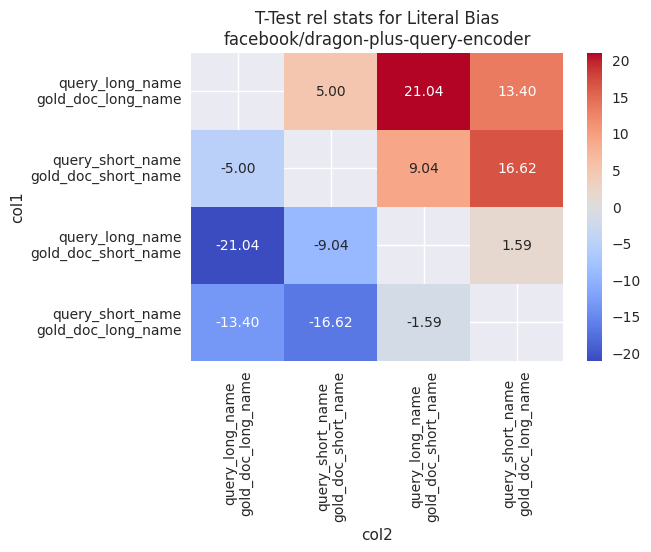

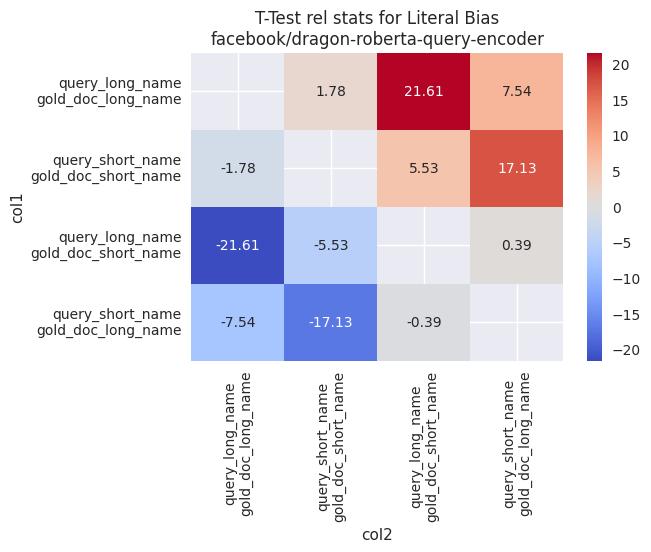

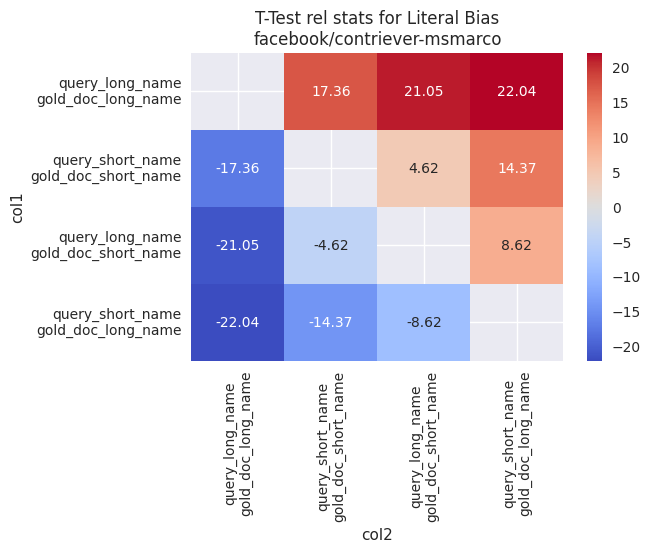

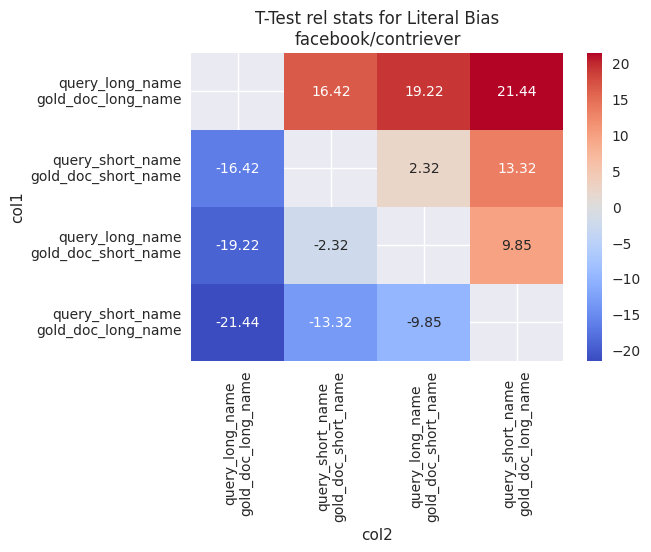

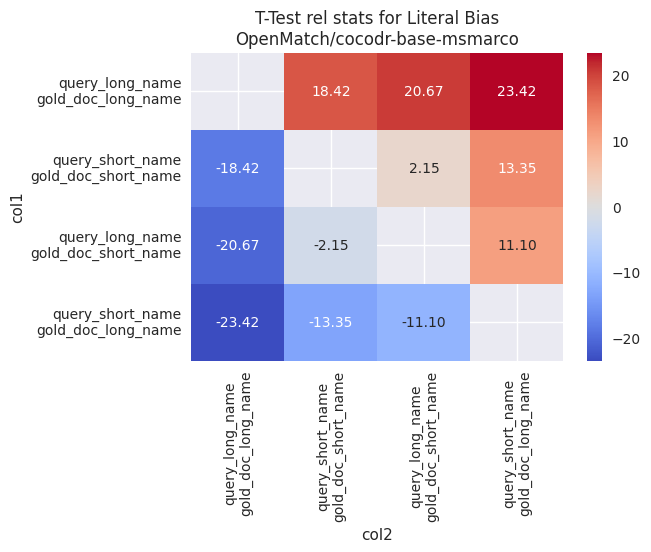

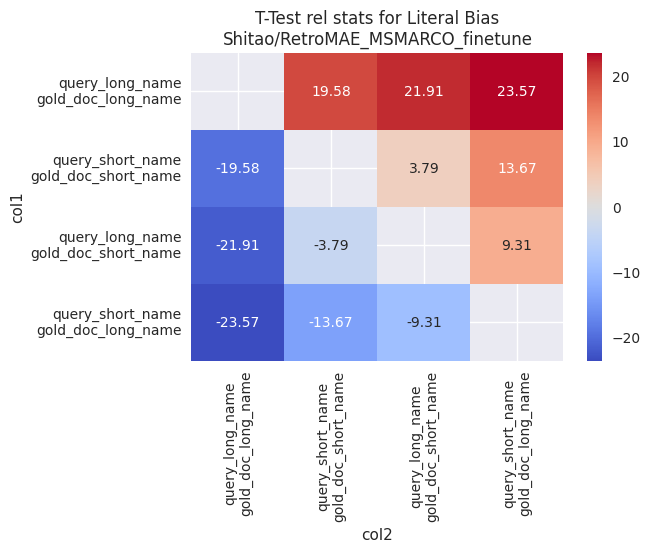

,query_model,col1,col2,ttest_stats,ttest_pvalue
0,facebook/dragon-plus-query-encoder,query_long_name\ngold_doc_long_name,query_long_name\ngold_doc_long_name,NaN,NaN
1,facebook/dragon-plus-query-encoder,query_long_name\ngold_doc_long_name,query_short_name\ngold_doc_long_name,13.396053,3.505318e-31
2,facebook/dragon-plus-query-encoder,query_long_name\ngold_doc_long_name,query_long_name\ngold_doc_short_name,21.035999,3.724149e-57
3,facebook/dragon-plus-query-encoder,query_long_name\ngold_doc_long_name,query_short_name\ngold_doc_short_name,4.998022,1.092529e-06
4,facebook/dragon-plus-query-encoder,query_short_name\ngold_doc_long_name,query_long_name\ngold_doc_long_name,-13.396053,3.505318e-31
...,...,...,...,...,...
11,Shitao/RetroMAE_MSMARCO_finetune,query_long_name\ngold_doc_short_name,query_short_name\ngold_doc_short_name,-3.787004,1.911888e-04
12,Shitao/RetroMAE_MSMARCO_finetune,query_short_name\ngold_doc_short_name,query_long_name\ngold_doc_long_name,-19.579732,2.613434e-52
13,Shitao/RetroMAE_MSMARCO_finetune,query_short_name\ngold_doc_short_name,query_short_name\ngold_doc_long_name,13.672860,4.002202e-32
14,Shitao/RetroMAE_MSMARCO_finetune,query_short_name\ngold_doc_short_name,query_long_name\ngold_doc_short_name,3.787004,1.911888e-04


In [6]:
cfgs = [
    ("facebook/dragon-plus-query-encoder", "facebook/dragon-plus-context-encoder", "cls"),
    ("facebook/dragon-roberta-query-encoder", "facebook/dragon-roberta-context-encoder", "cls"),
    ("facebook/contriever-msmarco", "facebook/contriever-msmarco", "avg"),
    ("facebook/contriever", "facebook/contriever", "avg"),
    ("OpenMatch/cocodr-base-msmarco", "OpenMatch/cocodr-base-msmarco", "cls"),
    ("Shitao/RetroMAE_MSMARCO_finetune", "Shitao/RetroMAE_MSMARCO_finetune", "cls"),
    
    # ("google-bert/bert-base-uncased", "google-bert/bert-base-uncased", "cls"),
    # ("FacebookAI/roberta-base", "FacebookAI/roberta-base", "cls")
    
    # ("Shitao/RetroMAE", "Shitao/RetroMAE", "cls"),
    # ("Shitao/RetroMAE_MSMARCO", "Shitao/RetroMAE_MSMARCO", "cls"),
]
query_cols = [
    # "query", 
    "query_long_name", "query_short_name"
]
doc_cols = [
    # "gold_doc_text", 
    "gold_doc_long_name", "gold_doc_short_name"
]

results_df = pd.DataFrame()
for query_model, context_model, POOLING in tqdm(cfgs):
    dpr = YourCustomDEModel(query_model, context_model, POOLING, verbose=False)
    def to_doc_format(sentences: list):
        return [{"text": s} for s in sentences]
    
    plot_col_dots = []
    
    for d_col in doc_cols:
        embds = dpr.encode_corpus(to_doc_format(df[d_col].to_list()))
        for q_col in query_cols:
            query_embds = dpr.encode_queries(df[q_col].to_list())
            embds_dot = torch.einsum("bd,bd->b", torch.tensor(query_embds), torch.tensor(embds))
            new_col = f"{q_col}\n{d_col}"
            # print(new_col)
            df[new_col] = embds_dot.cpu().numpy()
            plot_col_dots.append(new_col)
    
    # df[plot_col_dots[::-1]].boxplot(figsize=(9, 5), rot=0, vert=False)
    # plt.title(f"{query_model}, support: {len(df)}")
    # plt.show()
    
    ### T-TEST
    rdf = []
    for col1 in plot_col_dots:
        for col2 in plot_col_dots:
            rdf.append({
                "query_model": query_model,
                "col1": col1,
                "col2": col2,
                "ttest_stats": stats.ttest_rel(df[col1], df[col2])[0],
                "ttest_pvalue": stats.ttest_rel(df[col1], df[col2])[1],
            })
    rdf = pd.DataFrame(rdf)
    results_df = pd.concat([results_df, rdf])
    rdfp = rdf.pivot(index="col1", columns="col2", values="ttest_stats")
    order = [
        'query_long_name\ngold_doc_long_name', 
        'query_short_name\ngold_doc_short_name', 
        'query_long_name\ngold_doc_short_name',
        'query_short_name\ngold_doc_long_name',
    ]
    rdfp = rdfp.reindex(columns=order, level='col2')  # Sort columns
    rdfp = rdfp.reindex(order)
    plt.figure(figsize=(6, 4))
    sns.heatmap(rdfp, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title(f"T-Test rel stats for Literal Bias\n{query_model}")
    plt.show()
    rdf
    

# results.append({
#     "query_model": query_model,
#     "context_model": context_model,
#     "POOLING": POOLING,
#     "support": len(df),
#     "query_type": q,
#     "sents_complete_w_end_dot_vs_wo": stats.ttest_rel(df["sents_complete_w_end_dot"], df["sents_complete_wo_end_dot"]),
#     "head_w_tail_dot_vs_wo": stats.ttest_rel(df["head_w_tail_dot"], df["head_wo_tail_dot"]),
#     "sents_complete_rm_wo_dot_vs_w": stats.ttest_rel(df["sents_complete_rm_head_wo_tail_dot"], df["sents_complete_rm_head_w_tail_dot"]),
# })
results_df

In [10]:
df = results_df.dropna().copy()

# df["col"] = df["col1"] + " vs " + df["col2"]
# df = df[(df["query_model"].str.contains("dragon-plus")) | (df["query_model"].str.contains("contriever-msmarco"))]

df["Query Name 1"] = df["col1"].apply(lambda x: x.split("\n")[0].split("_")[1])
df["Doc Name 1"] = df["col1"].apply(lambda x: x.split("\n")[1].split("_")[2])
df["Query Name 2"] = df["col2"].apply(lambda x: x.split("\n")[0].split("_")[1])
df["Doc Name 2"] = df["col2"].apply(lambda x: x.split("\n")[1].split("_")[2])
df = df[["query_model", "Query Name 1", "Doc Name 1", "Query Name 2", "Doc Name 2", "ttest_stats", "ttest_pvalue"]]
df = df[df["Query Name 1"] == df["Doc Name 1"]]
df = df[~((df["Query Name 2"] == "long") & (df["Doc Name 2"] == "long"))]
df = pd.pivot_table(
    df,
    values=[
        "ttest_stats", 
        # "ttest_pvalue",
    ],
    index=[
        "Query Name 1", "Doc Name 1", "Query Name 2", "Doc Name 2"
    ],
    columns=['query_model'], margins=False, aggfunc=lambda x: x.iloc[0] if len(x) == 1 else -100,
)

# LATEX
def clean_table(table_str):
    mappings = {
        "attention": "Attention",
    }
    model_mappings = {
        "OpenMatch/cocodr-base-msmarco": ("COCO-DR", "Base MSMARCO"),
        r"Shitao/RetroMAE\_MSMARCO\_finetune": ("RetroMAE", "MSMARCO FT"),
        r"Shitao/RetroMAE\_MSMARCO": ("RetroMAE", "MSMARCO"),
        "Shitao/RetroMAE": ("RetroMAE", ""),
        "facebook/contriever-msmarco": ("Contriever", "MSMARCO"),
        "facebook/contriever": ("Contriever", ""),
        "facebook/dragon-plus-query-encoder": ("Dragon+", ""),
        "facebook/dragon-roberta-query-encoder": ("Dragon", "RoBERTa"),
    }
    back = "\\"
    raw_mappings = {
        # r"Method & Selection &  &  &  &  &  &  &  &  &  &  \\": "",
        r"query\_model": "Model",
        "llllrrrrrr": r"p{1.2cm}p{1.2cm}p{1.2cm}p{1.2cm}rrrrrr",
        r"\cline{1-10} \cline{2-10} \cline{3-10}": "\\midrule",
    }
    for k, v in mappings.items():
        key = k.replace('_', '\\_')
        table_str = table_str.replace("\\textbf{" + key + "}", "\\textsc{" + v + "}")
    for k, v in model_mappings.items():
        key = k
        value = r"\makecell{" + v[0] + r" \\ " + v[1] + r"}"
        table_str = table_str.replace(key, value)
    for k, v in raw_mappings.items():
        table_str = table_str.replace(k, v)
    return table_str
print(clean_table(df.round(2).to_latex(float_format="%.2f", bold_rows=True, ).replace("_", r"\_")))
# print(df.round(2).to_latex(float_format="%.2f", bold_rows=True, ).replace("_", "\_"))

df

\begin{tabular}{llllrr}
\toprule
 &  &  &  & \multicolumn{2}{r}{ttest\_stats} \\
 &  &  & Model & \makecell{Contriever \\ MSMARCO} & \makecell{Dragon+ \\ } \\
Query Name 1 & Doc Name 1 & Query Name 2 & Doc Name 2 &  &  \\
\midrule
\multirow[t]{3}{*}{\textbf{long}} & \multirow[t]{3}{*}{\textbf{long}} & \textbf{long} & \textbf{short} & 21.05 & 21.04 \\
\cline{3-6}
\textbf{} & \textbf{} & \multirow[t]{2}{*}{\textbf{short}} & \textbf{long} & 22.04 & 13.40 \\
\textbf{} & \textbf{} & \textbf{} & \textbf{short} & 17.36 & 5.00 \\
\cline{1-6} \cline{2-6} \cline{3-6}
\multirow[t]{2}{*}{\textbf{short}} & \multirow[t]{2}{*}{\textbf{short}} & \textbf{long} & \textbf{short} & 4.62 & 9.04 \\
\cline{3-6}
\textbf{} & \textbf{} & \textbf{short} & \textbf{long} & 14.37 & 16.62 \\
\cline{1-6} \cline{2-6} \cline{3-6}
\bottomrule
\end{tabular}



ttest_stats  \
query_model                                     facebook/contriever-msmarco   
Query Name 1 Doc Name 1 Query Name 2 Doc Name 2                               
long         long       long         short                        21.052906   
                        short        long                         22.042021   
                                     short                        17.357773   
short        short      long         short                         4.622175   
                        short        long                         14.367365   

                                                                                    
query_model                                     facebook/dragon-plus-query-encoder  
Query Name 1 Doc Name 1 Query Name 2 Doc Name 2                                     
long         long       long         short                               21.035999  
                        short        long                                13.396053  
                                     short                                4.998022  
short        short      long         short                                9.043239  
                        short        long                                16.615255

In [8]:
order = [
    'query_long_name\ngold_doc_long_name', 
    'query_short_name\ngold_doc_short_name', 
    'query_long_name\ngold_doc_short_name',
    'query_short_name\ngold_doc_long_name',
]
rdfp2 = rdfp.reindex(columns=order, level='col2')  # Sort columns
rdfp2 = rdfp2.reindex(order)
rdfp2

col2,query_long_name\ngold_doc_long_name,query_short_name\ngold_doc_short_name,query_long_name\ngold_doc_short_name,query_short_name\ngold_doc_long_name
col1,,,,
query_long_name\ngold_doc_long_name,NaN,19.579732,21.905897,23.571365
query_short_name\ngold_doc_short_name,-19.579732,NaN,3.787004,13.672860
query_long_name\ngold_doc_short_name,-21.905897,-3.787004,NaN,9.309085
query_short_name\ngold_doc_long_name,-23.571365,-13.672860,-9.309085,NaN


# Ttest Binary [FINAL]

In [8]:
df = df_raw.copy()
df = df[df["head_entity_names"].str.len() > 1]
df = df[df["evidence_sent_ids"].str.len() == 1]  # 1 Evidence
print(len(df))

# df = df.groupby('title').tail(1)
df = df.drop_duplicates(subset=["title"])
print(len(df))

df = df.sample(250, random_state=1)
print(len(df))

# df["head_entity_shortest_name"] = df["head_entity_names"].apply(lambda x: min(x, key=len))
df["head_entity_shortest_name"] = df.apply(lambda r: min([n for n in r['head_entity_names'] if n != r["head_entity_longest_name"]], key=len), axis=1)
df["query_long_name"] = df["query"]
df["query_short_name"] = df.apply(lambda r: r["query"].replace(r["head_entity_longest_name"], r["head_entity_shortest_name"]), axis=1)

def replace_heads(r, replacement):
    sents = r["sents"]
    head_all_pos = []
    head_start_pos = []
    for e in r["head_entity"]:
        if "".join(sents[e["sent_id"]][e["pos"][0]: e["pos"][1]]).replace(" ", "") != e["name"].replace(" ", ""):
            print("ERROR", e["name"].replace(" ", ""), " != ", "".join(sents[e["sent_id"]][e["pos"][0]: e["pos"][1]]).replace(" ", ""))
        head_start_pos.append((e["sent_id"], e["pos"][0]))
        for i in range(e["pos"][0], e["pos"][1]):
            head_all_pos.append((e["sent_id"], i))
        
    new_words = []
    for sent_id, sent in enumerate(sents):
        for wi, word in enumerate(sent):
            if (sent_id, wi) in head_start_pos:
                new_words.append(replacement)
            if (sent_id, wi) not in head_all_pos:
                new_words.append(word)
    return " ".join(new_words)

print(df["title"].value_counts())

df["gold_doc_long_name"] = df.apply(lambda r: replace_heads(r, r["head_entity_longest_name"]), axis=1)
df["gold_doc_short_name"] = df.apply(lambda r: replace_heads(r, r["head_entity_shortest_name"]), axis=1)

save_cols = [
    "query", "gold_docs", "gold_docs_text", "scores_stats", "scores_gold", "predicted_docs_text_10", "id", "title", "vertexSet", 
    "labels", "sents", "split", "label", "label_idx", "head_entity", 
    "tail_entity", "head_entity_names", "tail_entity_names", 
    "head_entity_longest_name", "tail_entity_longest_name", 
    "head_entity_types", "tail_entity_types", "evidence_sent_ids", 
    "evidence_sents", "head_entity_in_evidence", "tail_entity_in_evidence", 
    "relation", "relation_name", "query_question", "duplicate_titles_len", 
    "duplicate_titles", "hit_rank", "gold_doc", "gold_doc_title", 
    "gold_doc_text", "gold_doc_score", "pred_doc", "pred_doc_title", 
    "pred_doc_text", "pred_doc_score", "gold_doc_len", "pred_doc_len",
] + ["query_long_name", "query_short_name", "gold_doc_long_name", "gold_doc_short_name"]
df[save_cols].to_json("dataset/literal_bias.jsonl", orient="records", lines=True)

df[["query", "query_long_name", "query_short_name", "gold_doc_long_name", "gold_doc_short_name"]].sample(5)
df[df["gold_doc_long_name"].str.contains("Iran")][["query", "gold_doc_long_name", "head_entity_longest_name", "head_entity_shortest_name"]]

1072
411
250
title
Christine Razanamahasoa    1
Ernst-Ludwig Schwandner    1
Joseph Alexander Cooper    1
Kokumin Dōmei              1
Leone Marucci              1
                          ..
Jonathan Joss              1
Gordon Persons             1
Ross Alger                 1
Arcadia (band)             1
Christie Elliott           1
Name: count, Length: 250, dtype: int64
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR 0.
TheSwingles  !=  TheSwingles
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR 0.
TheSwingles  !=  TheSwingles


,query,gold_doc_long_name,head_entity_longest_name,head_entity_shortest_name
5380,When was Houshang Seyhoun born?,"Houshang Seyhoun , ( ) ( August 22 , 1920 – May 26 , 2014 ) was an Iranian architect , sculptor , painter , scholar and professor . He studied fine arts at the École nationale supérieure des Beaux - Arts in Paris , and earned a degree in architecture f...",Houshang Seyhoun,Seyhun
5675,When was Abbas Kiarostami born?,"Abbas Kiarostami ( ; 22 June 1940 – 4 July 2016 ) was an Iranian film director , screenwriter , poet , photographer and film producer . An active film - maker from 1970 , Abbas Kiarostami had been involved in over forty films , including shorts and doc...",Abbas Kiarostami,Kiarostami


In [9]:
sents_cols = [("query_short_name", "gold_doc_short_name"), ("query_short_name", "gold_doc_long_name"),]

In [13]:
### RUN MODELS AND COMPUTE DOT SCORES
def digitize_col(df_col, bins) -> pd.DataFrame:
    return pd.cut(df_col, bins=bins)

cfgs = [
    ("facebook/dragon-plus-query-encoder", "facebook/dragon-plus-context-encoder", "cls"),
    ("facebook/dragon-roberta-query-encoder", "facebook/dragon-roberta-context-encoder", "cls"),
    ("facebook/contriever-msmarco", "facebook/contriever-msmarco", "avg"),
    ("facebook/contriever", "facebook/contriever", "avg"),
    ("OpenMatch/cocodr-base-msmarco", "OpenMatch/cocodr-base-msmarco", "cls"),
    ("Shitao/RetroMAE_MSMARCO_finetune", "Shitao/RetroMAE_MSMARCO_finetune", "cls"),
    
    ("google-bert/bert-base-uncased", "google-bert/bert-base-uncased", "avg"),
    ("FacebookAI/roberta-base", "FacebookAI/roberta-base", "avg")
    
    # ("Shitao/RetroMAE", "Shitao/RetroMAE", "cls"),
    # ("Shitao/RetroMAE_MSMARCO", "Shitao/RetroMAE_MSMARCO", "cls"),
]

plot_col_dots = []
for query_model, context_model, POOLING in tqdm(cfgs):
    dpr = YourCustomDEModel(query_model, context_model, POOLING, verbose=False)
    def to_doc_format(sentences: list):
        return [{"text": s} for s in sentences]
    for query_col, sent_col in tqdm(sents_cols, desc=f"{query_model}"):
        query_embds = dpr.encode_queries(df[query_col].to_list())
        embds = dpr.encode_corpus(to_doc_format(df[sent_col].to_list()))
        embds_dot = torch.einsum("bd,bd->b", torch.tensor(query_embds), torch.tensor(embds)).cpu().numpy()
        new_col = f"{query_model}_{query_col}{sent_col}_dot"
        # print(new_col)
        df[new_col] = embds_dot
        plot_col_dots.append(new_col)

df_dot = df.copy()

  0%|          | 0/8 [00:00<?, ?it/s]

facebook/dragon-plus-query-encoder:   0%|          | 0/2 [00:00<?, ?it/s]

facebook/dragon-roberta-query-encoder:   0%|          | 0/2 [00:00<?, ?it/s]

facebook/contriever-msmarco:   0%|          | 0/2 [00:00<?, ?it/s]

facebook/contriever:   0%|          | 0/2 [00:00<?, ?it/s]

OpenMatch/cocodr-base-msmarco:   0%|          | 0/2 [00:00<?, ?it/s]

Shitao/RetroMAE_MSMARCO_finetune:   0%|          | 0/2 [00:00<?, ?it/s]

google-bert/bert-base-uncased:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FacebookAI/roberta-base:   0%|          | 0/2 [00:00<?, ?it/s]

In [14]:
df_dot.head(1)

,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokenizer_word_ids,query_decompx_cls_or_mean_pooled,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_pooled,gold_doc_decompx_tokens,gold_doc_decompx_tokenizer_word_ids,gold_doc_decompx_cls_or_mean_pooled,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_pooled,pred_doc_decompx_tokens,pred_doc_decompx_tokenizer_word_ids,pred_doc_decompx_cls_or_mean_pooled,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_pooled,head_entity_shortest_name,query_long_name,query_short_name,gold_doc_long_name,gold_doc_short_name,facebook/dragon-plus-query-encoder_query_short_namegold_doc_short_name_dot,facebook/dragon-plus-query-encoder_query_short_namegold_doc_long_name_dot,facebook/dragon-roberta-query-encoder_query_short_namegold_doc_short_name_dot,facebook/dragon-roberta-query-encoder_query_short_namegold_doc_long_name_dot,facebook/contriever-msmarco_query_short_namegold_doc_short_name_dot,facebook/contriever-msmarco_query_short_namegold_doc_long_name_dot,facebook/contriever_query_short_namegold_doc_short_name_dot,facebook/contriever_query_short_namegold_doc_long_name_dot,OpenMatch/cocodr-base-msmarco_query_short_namegold_doc_short_name_dot,OpenMatch/cocodr-base-msmarco_query_short_namegold_doc_long_name_dot,Shitao/RetroMAE_MSMARCO_finetune_query_short_namegold_doc_short_name_dot,Shitao/RetroMAE_MSMARCO_finetune_query_short_namegold_doc_long_name_dot,google-bert/bert-base-uncased_query_short_namegold_doc_short_name_dot,google-bert/bert-base-uncased_query_short_namegold_doc_long_name_dot,FacebookAI/roberta-base_query_short_namegold_doc_short_name_dot,FacebookAI/roberta-base_query_short_namegold_doc_long_name_dot
4664,validation4652,Which country is Christine Harijaona Razanamahasoa a citizen of?,[Christine Razanamahasoa],"{'Christine Razanamahasoa': {'text': 'Christine Harijaona Razanamahasoa is a Malagasy politician . She served as a Minister of Justice between 2009 and 2013 , and as the president of the Malagasy National Assembly from February till May 2014 , becoming...","{'len': 1000, 'max': 391.48480224609375, 'min': 378.3471374511719, 'std': 1.1422349851193925, 'mean': 379.5190133972168, 'median': 379.21080017089844}",{'Christine Razanamahasoa': 391.48480224609375},"{'Christine Razanamahasoa': 391.48480224609375, 'Lalao Ravalomanana': 387.03485107421875, 'Krishna Chudasama': 385.37200927734375, 'Tahina Razafindramary': 385.32244873046875, 'Joanna Manganara': 384.7535705566406, 'Christine de Pizan': 384.20892333984...","{'Christine Razanamahasoa': {'text': 'Christine Harijaona Razanamahasoa is a Malagasy politician . She served as a Minister of Justice between 2009 and 2013 , and as the president of the Malagasy National Assembly from February till May 2014 , becoming...",validation4652,Christine Razanamahasoa,"[[{'type': 'PER', 'pos': [0, 3], 'name': 'Christine Harijaona Razanamahasoa', 'sent_id': 0, 'global_pos': [0, 0], 'index': '0_0'}, {'name': 'Christine Razanamahasoa', 'pos': [0, 2], 'sent_id': 5, 'type': 'PER', 'global_pos': [112, 112], 'index': '0_1'}...","[{'r': 'P27', 'h': 0, 't': 1, 'evidence': [0]}, {'r': 'P102', 'h': 0, 't': 18, 'evidence': [0, 9, 12]}, {'r': 'P1001', 'h': 5, 't': 1, 'evidence': []}, {'r': 'P17', 'h': 5, 't': 1, 'evidence': []}, {'r': 'P27', 'h': 9, 't': 1, 'evidence': [3]}, {'r': '...","[[Christine, Harijaona, Razanamahasoa, is, a, 

['facebook/dragon-plus-query-encoder_query_short_namegold_doc_short_name_dot', 'facebook/dragon-plus-query-encoder_query_short_namegold_doc_long_name_dot', 'facebook/dragon-roberta-query-encoder_query_short_namegold_doc_short_name_dot', 'facebook/dragon-roberta-query-encoder_query_short_namegold_doc_long_name_dot', 'facebook/contriever-msmarco_query_short_namegold_doc_short_name_dot', 'facebook/contriever-msmarco_query_short_namegold_doc_long_name_dot', 'facebook/contriever_query_short_namegold_doc_short_name_dot', 'facebook/contriever_query_short_namegold_doc_long_name_dot', 'OpenMatch/cocodr-base-msmarco_query_short_namegold_doc_short_name_dot', 'OpenMatch/cocodr-base-msmarco_query_short_namegold_doc_long_name_dot', 'Shitao/RetroMAE_MSMARCO_finetune_query_short_namegold_doc_short_name_dot', 'Shitao/RetroMAE_MSMARCO_finetune_query_short_namegold_doc_long_name_dot', 'google-bert/bert-base-uncased_query_short_namegold_doc_short_name_dot', 'google-bert/bert-base-uncased_query_short_nameg

  0%|          | 0/8 [00:00<?, ?it/s]

,Model,col1,col2,Paired t-Test Statistic,ttest_pvalue,ttest_ci_low,ttest_ci_high,mean_diff,std_diff,n
0,BERT Base Uncased,google-bert/bert-base-uncased_query_short_namegold_doc_short_name_dot,google-bert/bert-base-uncased_query_short_namegold_doc_long_name_dot,6.436391,6.239153e-10,1.650996,1.650996,0.261232,0.641733,250
0,RoBERTa Base,FacebookAI/roberta-base_query_short_namegold_doc_short_name_dot,FacebookAI/roberta-base_query_short_namegold_doc_long_name_dot,10.428220,2.315247e-21,1.650996,1.650996,0.684406,1.037705,250
0,Contriever,facebook/contriever_query_short_namegold_doc_short_name_dot,facebook/contriever_query_short_namegold_doc_long_name_dot,13.330195,5.868572e-31,1.650996,1.650996,0.118967,0.141110,250
0,COCO-DR Base MSMARCO,OpenMatch/cocodr-base-msmarco_query_short_namegold_doc_short_name_dot,OpenMatch/cocodr-base-msmarco_query_short_namegold_doc_long_name_dot,13.421355,2.875399e-31,1.650996,1.650996,1.965250,2.315215,250
0,RetroMAE MSMARCO FT,Shitao/RetroMAE_MSMARCO_finetune_query_short_namegold_doc_short_name_dot,Shitao/RetroMAE_MSMARCO_finetune_query_short_namegold_doc_long_name_dot,13.715352,2.866787e-32,1.650996,1.650996,3.444002,3.970329,250
0,Contriever MSMARCO,facebook/contriever-msmarco_query_short_namegold_doc_short_name_dot,facebook/contriever-msmarco_query_short_namegold_doc_long_name_dot,14.353309,1.886783e-34,1.650996,1.650996,0.187188,0.206203,250
0,Dragon+,facebook/dragon-plus-query-encoder_query_short_namegold_doc_short_name_dot,facebook/dragon-plus-query-encoder_query_short_namegold_doc_long_name_dot,16.671273,2.038058e-42,1.650996,1.650996,4.217728,4.000182,250
0,Dragon RoBERTa,facebook/dragon-roberta-query-encoder_query_short_namegold_doc_short_name_dot,facebook/dragon-roberta-query-encoder_query_short_namegold_doc_long_name_dot,17.229868,2.475146e-44,1.650996,1.650996,4.088110,3.751549,250


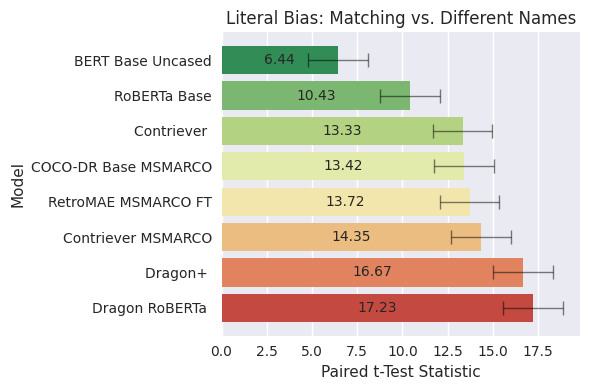

In [15]:
df = df_dot.copy()
print(plot_col_dots)

def standard_ttest_ppf(n, confidence_level=0.95):
    return stats.t.ppf(q=1-confidence_level, df=n-1, loc=0, scale=1)

results_df = pd.DataFrame()
for query_model, context_model, POOLING in tqdm(cfgs):
    ### T-TEST
    rdf = []
    for col1 in plot_col_dots:
        for col2 in plot_col_dots:
            if query_model == col1.split("_query")[0] and query_model == col2.split("_query")[0] and col1 != col2 and "query_short_namegold_doc_short" in col1:
                rdf.append({
                    "query_model": query_model,
                    "col1": col1,
                    "col2": col2,
                    "ttest_stats": stats.ttest_rel(df[col1], df[col2])[0],
                    "ttest_pvalue": stats.ttest_rel(df[col1], df[col2])[1],
                    "ttest_ci_low": np.abs(standard_ttest_ppf(len(df))),
                    "ttest_ci_high": np.abs(standard_ttest_ppf(len(df))),
                    "mean_diff": (df[col1] - df[col2]).mean(),
                    "std_diff": (df[col1] - df[col2]).std(),
                    "n": len(df),
                })
    rdf = pd.DataFrame(rdf)
    results_df = pd.concat([results_df, rdf]).sort_values("ttest_stats", ascending=True)

### PLOT
model_mappings = {
    "OpenMatch/cocodr-base-msmarco": ("COCO-DR", "Base MSMARCO"),
    "Shitao/RetroMAE_MSMARCO_finetune": ("RetroMAE", "MSMARCO FT"),
    "Shitao/RetroMAE_MSMARCO": ("RetroMAE", "MSMARCO"),
    "Shitao/RetroMAE": ("RetroMAE", ""),
    "facebook/contriever-msmarco": ("Contriever", "MSMARCO"),
    "facebook/contriever": ("Contriever", ""),
    "facebook/dragon-plus-query-encoder": ("Dragon+", ""),
    "facebook/dragon-roberta-query-encoder": ("Dragon RoBERTa", ""),
    "google-bert/bert-base-uncased": ("BERT", "Base Uncased"),
    "FacebookAI/roberta-base": ("RoBERTa", "Base"),
}
results_df["query_model"] = results_df["query_model"].apply(lambda x: model_mappings[x][0] + " " + model_mappings[x][1])
results_df.rename(columns={"ttest_stats": "Paired t-Test Statistic", "query_model": "Model"}, inplace=True)
plt.figure(figsize=(6, 4))
plt.title("Literal Bias: Matching vs. Different Names")
ax = sns.barplot(data=results_df, y="Model", x="Paired t-Test Statistic", palette=sns.color_palette("RdYlGn_r", n_colors=len(results_df["Model"].unique())), hue="Model")
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', fontsize=10)
ax.errorbar(x=results_df["Paired t-Test Statistic"], y=results_df["Model"], xerr=results_df[["ttest_ci_low", "ttest_ci_high"]].T.to_numpy(), fmt="none", c="k", capsize=5, elinewidth=1, markeredgewidth=1, alpha=0.5)
results_df.to_json("results/literal_df.json", orient="records")
# ax.bar_label(ax.containers[0], labels=[f"{s:.2f}" for s, p in zip(results_df["Paired t-Test Statistic"], results_df["ttest_pvalue"])], fontsize=10, fmt='%.2f', label_type='center', color='white')
# ax.bar_label(ax.containers[1], labels=[f"{s:.2f}" for s, p in zip(results_df["Paired t-Test Statistic"], results_df["ttest_pvalue"])], fontsize=10, fmt='%.2f', label_type='center', color='white')

plt.tight_layout()
plt.savefig("figs/literal_ttest.pdf")
results_df

In [74]:
# Find Example
pd.set_option('display.max_colwidth', 1800)
df = df_dot.copy()
df["diff"] = df["facebook/dragon-plus-query-encoder_query_short_namegold_doc_short_name_dot"] - df["facebook/dragon-plus-query-encoder_query_short_namegold_doc_long_name_dot"]
# df["evidence_text"] = df["evidence_sents"].apply(lambda x: " ".join(flatten(x)))
# df["evidence_len"] = df["evidence_text"].apply(lambda x: len(x.split()))
print(df["gold_doc_len"].describe())
# df = df[df["gold_doc_len"] < 150]
df = df[df["gold_doc_long_name"].str.contains("Iran")]
# df = df[df["evidence_sent_ids"].apply(lambda x: x[0]) == 0]
cols = [sents_cols[0][0], sents_cols[0][1], sents_cols[1][0], sents_cols[1][1]]
df = df[cols + ["title", "query", "diff", "head_entity_names", "tail_entity"]].sort_values("diff", ascending=False)
df

count    250.000000
mean     201.728000
std       60.137376
min      133.000000
25%      157.250000
50%      188.000000
75%      225.000000
max      460.000000
Name: gold_doc_len, dtype: float64


,query_short_name,gold_doc_short_name,query_short_name,gold_doc_long_name,title,query,diff,head_entity_names,tail_entity
5380,When was Seyhun born?,"Seyhun , ( ) ( August 22 , 1920 – May 26 , 2014 ) was an Iranian architect , sculptor , painter , scholar and professor . He studied fine arts at the École nationale supérieure des Beaux - Arts in Paris , and earned a degree in architecture from University of Tehran . Seyhun is noted specially for his innovative and creative architectural design . His architectural legacy includes countless monuments and over one thousand private villas . After the Iranian Revolution he moved to Vancouver and lived in exile until his death . Seyhun became famous for his design work in the 1950s in Iran , including : Tehran 's Central Railway Station and tombs of scientific / literary figures ( such as the Avicenna Mausoleum in Hamadan ) . He has been a faculty member of Tehran University 's College of Architecture , where he also served as Dean of the College of Fine Arts ( Beaux arts ) of Tehran University for six years .",When was Seyhun born?,"Houshang Seyhoun , ( ) ( August 22 , 1920 – May 26 , 2014 ) was an Iranian architect , sculptor , painter , scholar and professor . He studied fine arts at the École nationale supérieure des Beaux - Arts in Paris , and earned a degree in architecture from University of Tehran . Houshang Seyhoun is noted specially for his innovative and creative architectural design . His architectural legacy includes countless monuments and over one thousand private villas . After the Iranian Revolution he moved to Vancouver and lived in exile until his death . Houshang Seyhoun became famous for his design work in the 1950s in Iran , including : Tehran 's Central Railway Station and tombs of scientific / literary figures ( such as the Avicenna Mausoleum in Hamadan ) . He has been a faculty member of Tehran University 's College of Architecture , where he also served as Dean of the College of Fine Arts ( Beaux arts ) of Tehran University for six years .",Hooshang Seyhoun,When was Houshang Seyhoun born?,6.426239,"{Houshang Seyhoun, Seyhun, Seyhoon}","[{'pos': [6, 10], 'type': 'TIME', 'sent_id': 0, 'name': 'August 22 , 1920', 'global_pos': [6, 6], 'index': '1_0'}]"
5675,When was Kiarostami born?,"Kiarostami ( ; 22 June 1940 – 4 July 2016 ) was an Iranian film director , screenwriter , poet , photographer and film producer . An active film - maker from 1970 , Kiarostami had been involved in over forty films , including shorts and documentaries . Kiarostami attained critical acclaim for directing the Koker trilogy ( 1987 – 94 ) , Close - Up ( 1990 ) , Taste of Cherry ( 1997 ) – which was awarded the Palme d'Or at the Cannes Film Festival that year – and The Wind Will Carry Us ( 1999 ) . In his later works , Certified Copy ( 2010 ) and Like Someone in Love ( 2012 ) , he filmed for the first time outside Iran : in Italy and Japan , respectively . Kiarostami had worked extensively as a screenwriter , film editor , art director and producer and had designed credit titles and publicity material . He was also a poet , photographer , painter , illustrator , and graphic designer . He was part of a generation of filmmakers in the Iranian New Wave , a Persian cinema movement that started in the late 1960s and includes pioneering directors such as Bahram Beyzai , Nasser Taghvai , Ali Hatami , Masoud Kimiai , Dariush Mehrjui , Sohrab Shahid - Saless and Parviz Kimiavi . These filmmakers share many common techniques including the use of poetic dialogue and allegorical storytelling dealing with political and philosophical issues . Kiarostami had a reputation for using child protagonists , for documentary - style narrative films , for stories that take place in rural villages , and for conversations that unfold inside cars , using stationary mounted cameras . He is also known for his use of Persian poetry in the dialogue , titles , and themes of his films . Kiarostami 's films contain a nota